In [ ]:
!pip install imutils

## Pneumonia detection

Image classification challenge: trying to use chest x-rays to detect pneumonia in patients (i.e., assign a status of “pneumonia” or “normal” to each image)

### Dataset

[Chest-xray-pneumonia](http://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
* Folders `__MACOSX` and `chest_xray` are redundant, remove them.
* Every folder has two subfolders: `NORMAL` and `PNEUMONIA` that contain images of x-rays.

### Split and Visualize the Data

Validation set folder has only 16 images. That's too little. Let's re-split data to training, validation and test sets ourselves.

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from imutils import paths
from sklearn.model_selection import train_test_split

def generate_dataframe(directory):
    img_paths = list(paths.list_images(directory))
    labels = ['normal' if path.find('NORMAL') > -1 else 'pn' for path in img_paths]
    return pd.DataFrame({ 'paths': img_paths, 'labels': labels })

# df contains paths to all images with corresponding labels
all_df = generate_dataframe('/home/przemek/Deep Learning/road-to-deep-learning/road-to-deep-learning/data/pneumonia-xrays/chest_xray')

train_dataset, test_dateset = train_test_split(all_df, test_size=0.2, random_state=42)

print(train_dataset['labels'].value_counts())
print(test_dateset['labels'].value_counts())

pn        3440
normal    1244
Name: labels, dtype: int64
pn        833
normal    339
Name: labels, dtype: int64


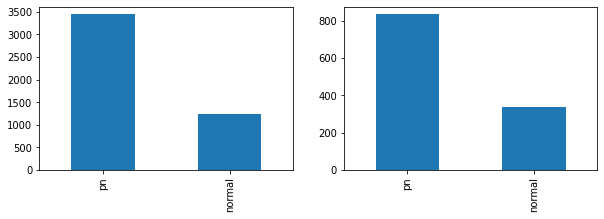

In [16]:
# show plots to check if datasets data distributions are similar
fig = plt.figure(figsize=(10,3))
for idx, dataset in enumerate([train_dataset, test_dateset]):
    fig.add_subplot(1,2,idx+1)
    dataset['labels'].value_counts().plot(kind='bar')

### Create Data Generators And Data Augmentation

Data generators are the way that our network can actually use the training
and test data we have stored in our data frames. Since our data frame only
contains the path to the image and the label, we would ideally like some
way of automatically reading those images into the computer’s memory so
that our soon-to-be-made neural network program can actually learn on it
(or be evaluated on images).

Steps for getting it into the network are roughly as follows:
* Read the picture files.
* Decode the JPEG content to RGB grids of pixels.
* Convert these into floating-point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know,
  neural networks prefer to deal with small input values).

Fortunately Keras has utilities to take care of these steps automatically.

Question:
* What is the purpose of data augmentation process?


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_generators(train_dataset, test_dateset, size=224, batch=64):
    train_generator = ImageDataGenerator(
        rescale=1./255, # multiply each pixel by value
        # augmentation params
        rotation_range=5, # randomly rotate each image by 0 to 5 degrees
        width_shift_range=0.1, # shift image horizontally by 0-10%
        height_shift_range=0.1, # shift image vertically by 0-10%
        validation_split=0.2  # creates two 'subsets': training and validation
    )
    # test on the data without any transformations (original data distribution!)
    test_generator = ImageDataGenerator(rescale=1./255)

    baseargs = {
        "x_col": 'paths',
        "y_col": 'labels',
        "class_labels": ['normal', 'pn'],
        "class_mode": 'binary',  # binary classification
        "target_size": (size, size),  # we can resize the images
        "batch_size": batch, # the number of images we present to the neural network at once
        "seed": 42
    }
    train_generator_flow = train_generator.flow_from_dataframe(
        **baseargs,
        dataframe=train_dataset,  # source data frame
        subset='training')
    validation_generator_flow = train_generator.flow_from_dataframe(
        **baseargs,
        dataframe=train_dataset,
        subset='validation')
    test_generator_flow = test_generator.flow_from_dataframe(
        dataframe=test_dateset,
        shuffle=False,
        **baseargs)

    return train_generator_flow, validation_generator_flow, test_generator_flow

Found 3748 validated image filenames belonging to 2 classes.
Found 936 validated image filenames belonging to 2 classes.
Found 1172 validated image filenames belonging to 2 classes.
(224, 224, 3)


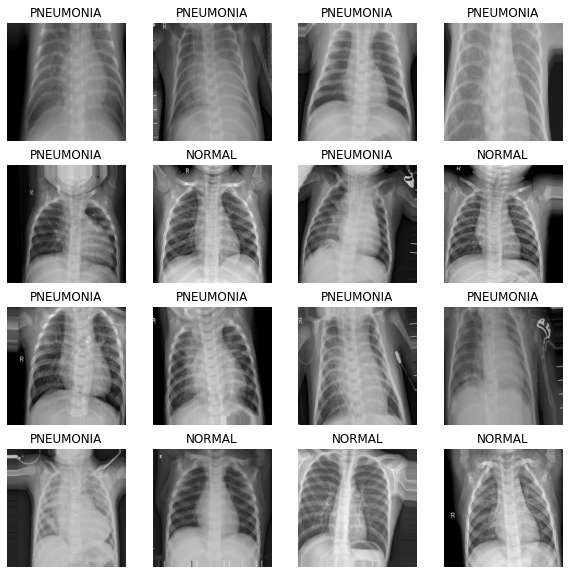

In [38]:
train_generator, validation_generator, test_generator = create_generators(train_dataset, test_dateset, 224, 32)

# display few images from training generator
imgs = train_generator.next() # get the first batch of images (16 images, 16 labels)
print(imgs[0][0].shape)
fig = plt.figure(figsize=(10,10), facecolor='white')
for i in range(16):
    fig.add_subplot(4,4,i+1)
    image = imgs[0][i]
    label = 'PNEUMONIA' if imgs[1][i] == 1 else 'NORMAL'
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)

### Create SmallNN

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.metrics import Recall, Precision, AUC

In [29]:

SIZE = 224
def make_smallnet():
    # Neural network architecture: sequential convolutional NN
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    # classic "dense" part
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[
                      'accuracy', Recall(name='recall'),
                      Precision(name='precision'), AUC(name='auc')
                  ])

    return model

### Set up 'callbacks'

In [40]:
from tensorflow.keras.utils import plot_model

def fit_model(train_generator, validation_generator, batch_size=32, epochs=15):
    model = make_smallnet()
    model.summary()
    plot_model(model, to_file='smallnn.jpg', show_shapes=True)

    model_history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_steps=validation_generator.n/batch_size,
                              epochs=epochs,
                              verbose=1)
    return model, model_history

In [41]:
small_model, small_model_hist = fit_model(train_generator, validation_generator, epochs=15)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 173056)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [42]:
def plot_history(history):

    fig = plt.figure(figsize = (18 , 6))

    fig.add_subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train loss', 'valid loss'])
    plt.grid(True)
    plt.plot()

    fig.add_subplot(1,2,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train acc', 'valid acc'])
    plt.grid(True)
    plt.plot()

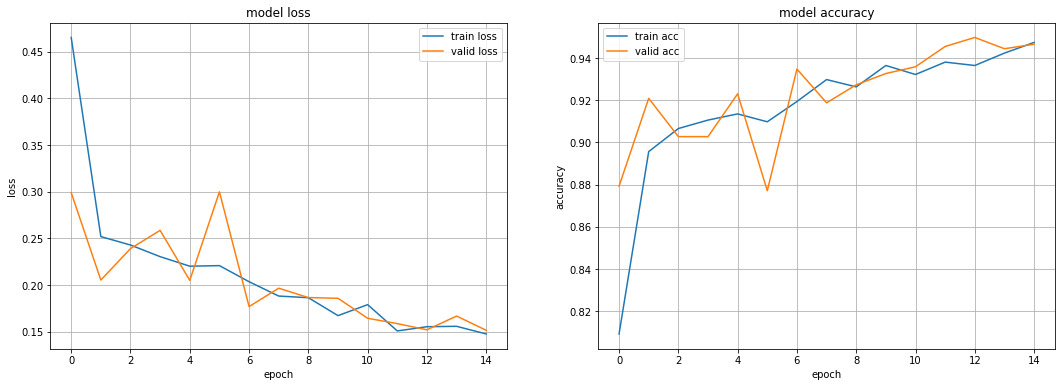

In [43]:
plot_history(small_model_hist)

## Assignment

* Conduct an experiment - what is accuracy with and without data augmentation?
* Describe how they work and purpose of following components of neural networks:
  * Loss function,
  * Optimization algorithm,
  * Activation function,
  * Accuracy, Recall and Precision metrics.
* Describe Convolution and Max pooling operations used in Convolutional Neural Networks.
* Describe what are "Python generators". Write simple generator which will yield images in form of TF tensors from `/chest_xray/train/` directory. Hint: use `tf.io.decode_jpeg` method.